# **Projet** **de** **Machine** **learning**: **Segmentation** **des** **clients**

  **Rédigé** **par:**

*   AICHA OUSSEINI :  **M2** **SBD**
*   GUEKAM FIRMIN Donatien :**M2** **ACT**



    

## Contexte:
Ce projet explore la segmentation des clients dans un contexte commercial, en exploitant des données structurées pour identifier des groupes homogènes au sein d'une clientèle.

## Chargement et prétraitement des données

In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('mall_customers.csv')
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [32]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Il y a 5 colonnes :

- **Customer ID** : numérique - numéro unique attribué à chaque client - entier.
- **Gender** : catégorielle - binaire (Homme/Femme).
- **Age** : numérique - entier.
- **Annual Income (k$)** : numérique - revenu annuel en milliers de dollars - entier.
- **Spending Score (1-100)** : numérique - score de dépense (entre 1 et 100) - entier.

In [33]:
df.isnull().sum()

,0
customer_id,0
gender,0
age,0
annual_income,0
spending_score,0


In [34]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## Exploration des données:
Dans ce chapitre, les distributions des variables numériques seront étudiées en détail. Les données seront stratifiées par genre, qui est la seule variable catégorielle.


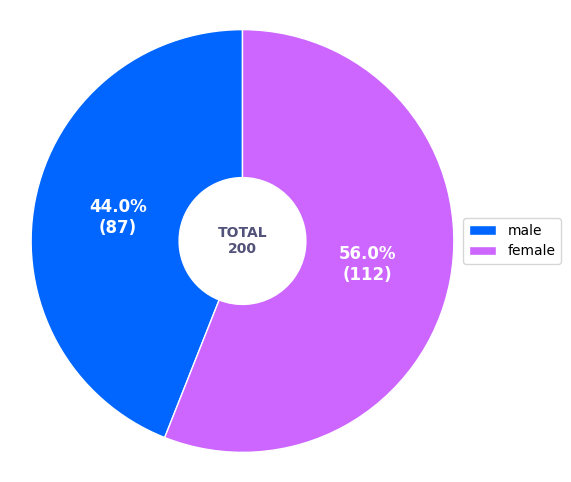

In [35]:

males_age = df[df['gender']=='Male']['age'] # subset with males age
females_age = df[df['gender']=='Female']['age'] # subset with females age

age_bins = range(15,75,5)

def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(df['age'].count()),
         weight='bold', size=10, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

Il y a légèrement plus de clientes que de clients (112 contre 87). Les femmes représentent 56% de la clientèle totale.

## **Corrélations**

#### Influence du genre sur la segmentation des clients.

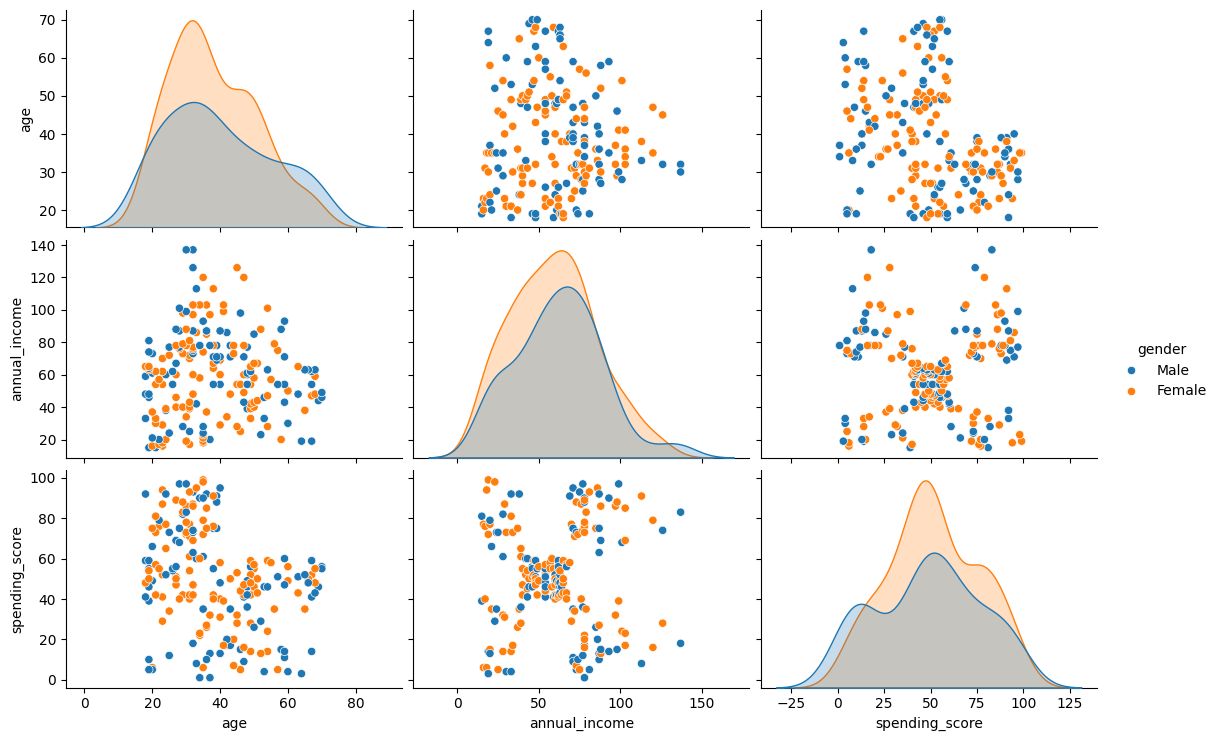

In [36]:
sns.pairplot(df.drop('customer_id', axis=1), hue='gender', aspect=1.5)
plt.show()

### Observation
Nous obervons que le genre ne permet pas de catégoriser les clients De même l'ID du client n'est pas informatif pour la catégorisation Nous pouvons les retirer des données.

Cela nous permet de rester avec des données quantitivaves

In [37]:
# Suppression des caractéristiques non déterminantes
X = df.drop(['customer_id', 'gender'], axis=1)

#### Regardons a présent la correlation entre les varibles numériques

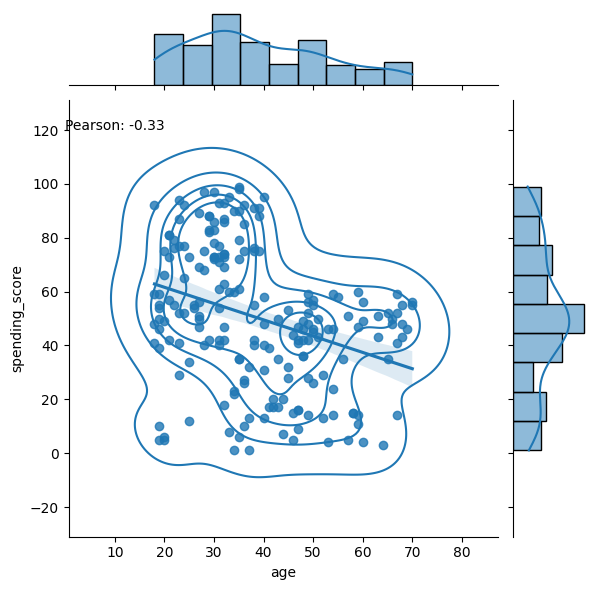

In [38]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# calculating Pearson's correlation
corr, _ = pearsonr(df['age'], df['spending_score'])

# Create the jointplot
jp = sns.jointplot(x='age', y='spending_score', data=df, kind='reg')

# Add the kdeplot to the joint axes
jp.plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0, 120, 'Pearson: {:.2f}'.format(corr))
plt.show()

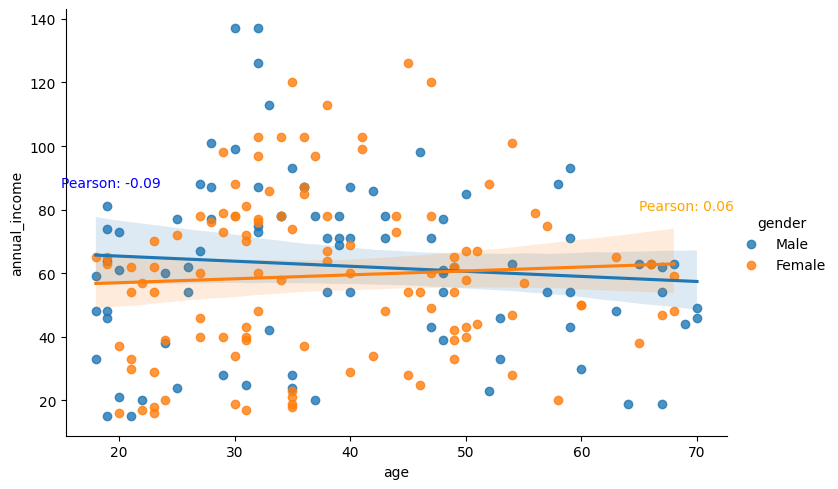

In [40]:
# calcul de la correlation de Pearson
males_income = df[df['gender'] == 'Male']['annual_income']
females_income = df[df['gender'] == 'Female']['annual_income']

corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(x='age', y='annual_income', data=df, hue='gender', aspect=1.5)

plt.text(15, 87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65, 80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

**Observation**: le coefficient de pearson etant faible autant pour les hommes que pour les femmes,on conclut que L’âge des clients n’a pratiquement aucune influence sur leur revenu annuel, quel que soit leur genre.

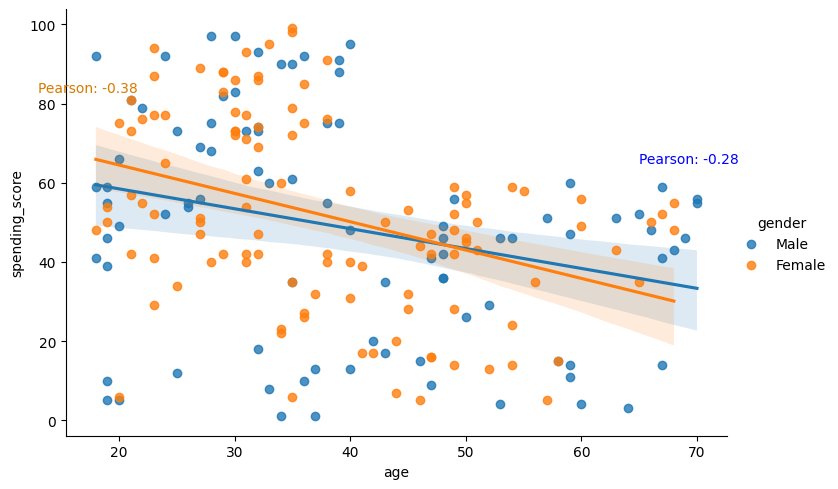

In [41]:
males_spending = df[df['gender']=='Male']['spending_score'] # subset with males age
females_spending = df[df['gender']=='Female']['spending_score'] # subset with females age

spending_bins = range(0,105,5)
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='age', y='spending_score', data=df, hue='gender', aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()




**Observation**: on observe une corrélation négative entre l'age et le revenu annuel pour les deux sexes

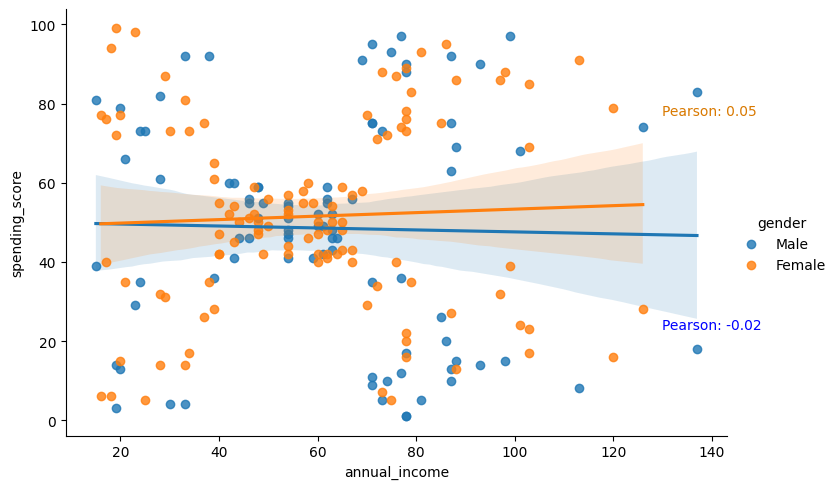

In [29]:
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(x='annual_income', y='spending_score', data=df, hue='gender', aspect=1.5)
plt.text(130, 23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130, 77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()


**Observation**: on observe une relation négligeable entre le score de depenses et le revenue annuel

# **Clustering** **avec** **l'algorithme** **DBSCAN**

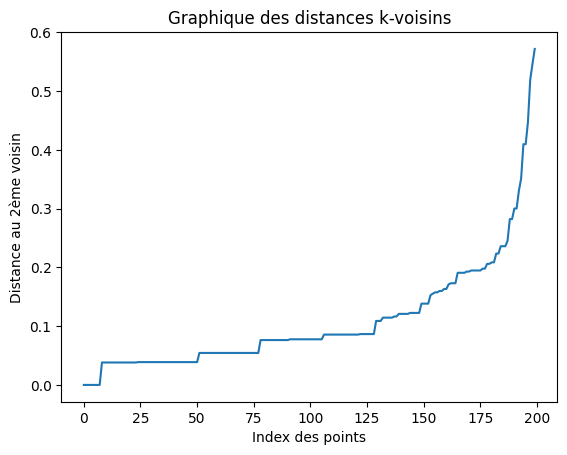

In [44]:
 # Préparer les données
X = df[['spending_score', 'annual_income']]
X_scaled = StandardScaler().fit_transform(X)
# Graphique des distances k-voisins
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)  # Attention à utiliser X_scaled ici pour la cohérence
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title('Graphique des distances k-voisins')
plt.xlabel('Index des points')
plt.ylabel('Distance au 2ème voisin')
plt.show()

d'après le graphique des **k-voisins**, les valeurs possibles de **esp** sont: **0.1**, **0.19**, **0.2**, **0.3**




#### **Implémentation** **de** **l'algorithme** **DBSCAN** **et** **evaluation** **avec** **le** **silhouette_score**

Silhouette Score pour eps=0.1: 0.5632777273524515


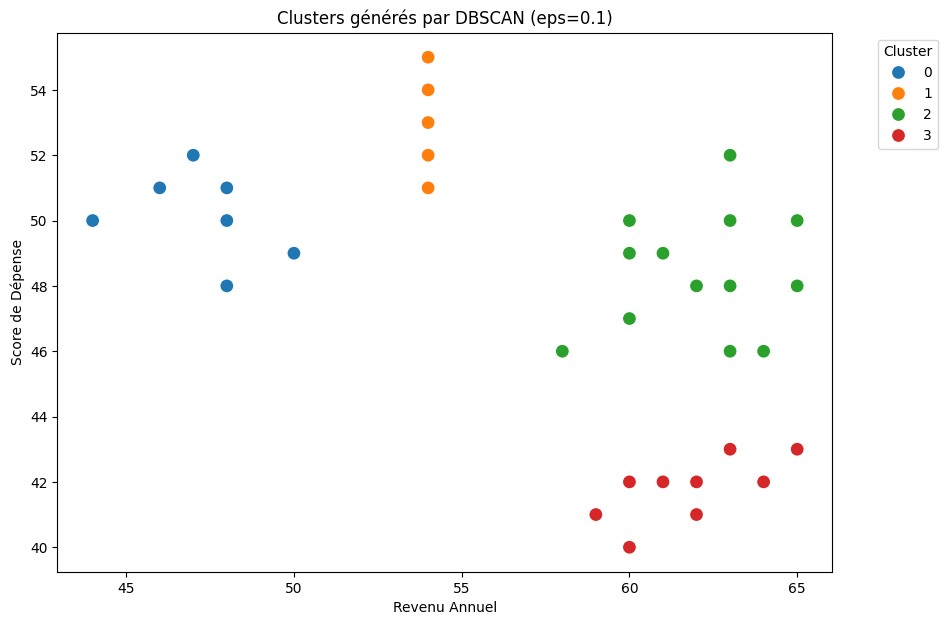

Silhouette Score pour eps=0.19: 0.6346192031379984


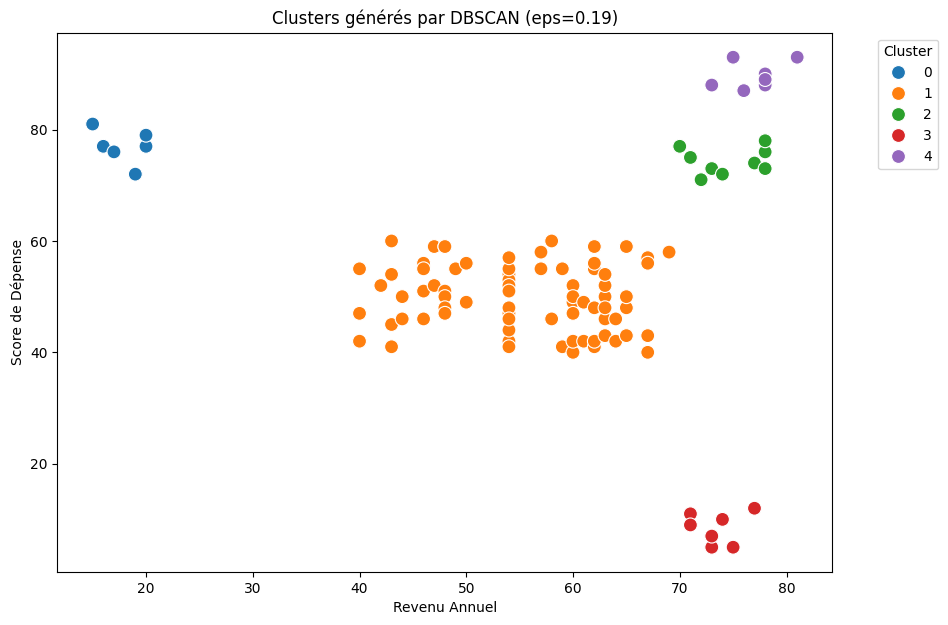

Silhouette Score pour eps=0.2: 0.5856126991466909


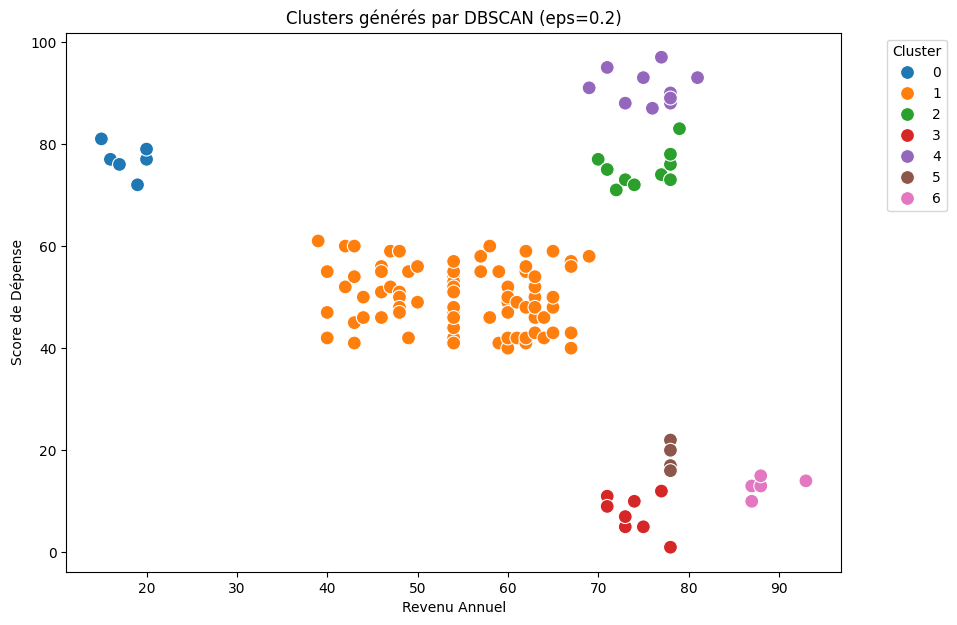

Silhouette Score pour eps=0.3: 0.524327610588142


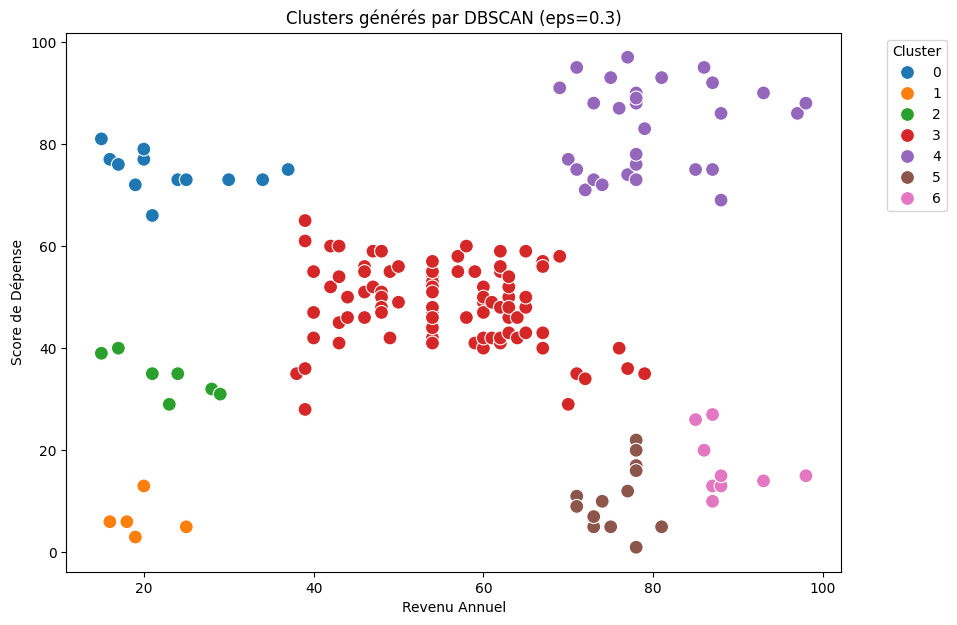

In [45]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tester différentes valeurs d'eps
eps_values = [0.1, 0.19, 0.2, 0.3]  # Ajustez selon le graphique k-voisin
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    y_pred = dbscan.fit_predict(X_scaled)

    # Filtrer les points clusterisés
    mask = y_pred != -1
    X_filtered = X_scaled[mask]
    y_filtered = y_pred[mask]

    # Calculer Silhouette Score
    if len(set(y_filtered)) > 1:  # Silhouette nécessite au moins 2 clusters
        score = silhouette_score(X_filtered, y_filtered)
        print(f"Silhouette Score pour eps={eps}: {score}")
    else:
        print(f"Pas assez de clusters pour eps={eps}")

    # Visualiser les clusters
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=X.iloc[mask, 1],
        y=X.iloc[mask, 0],
        hue=y_filtered,
        palette='tab10',
        s=100
    )
    plt.title(f'Clusters générés par DBSCAN (eps={eps})')
    plt.xlabel('Revenu Annuel')
    plt.ylabel('Score de Dépense')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


**Observation:**
*  Silhouette Score pour eps=0.1: 0.
5632777273524515
*  Silhouette Score pour eps=0.19: 0.6346192031379984
*  Silhouette Score pour eps=0.2: 0.5856126991466909
*  Silhouette Score pour eps=0.3: 0.524327610588142

# Conclusion:
La valeur de eps = 0.19 donne le meilleur Silhouette Score (0.635). Cela signifie que cette configuration produit les clusters les plus distincts et les mieux séparés.
pour cette valeur de esp, on 5 groupes:
*  Groupe 1 (bleu) : Clients avec un faible revenu annuel mais une forte propension à dépenser.
*  Groupe 2 (violet) : Clients avec un revenu élevé et une forte propension à dépenser.
*  Groupe 3 (vert) : Clients avec un revenu élevé et un score de dépense modéré
*  Groupe 4 (rouge) : Clients avec un revenu élevé mais une faible propension à dépenser.
*  Groupe 5 (orange) : Clients avec un revenu moyen et une propension moyenne à dépenser






# Utilisation pour la segmentation client:

Les groupes identifiés peuvent guider la stratégie marketing :
*  Personnalisation des offres : Offrir des promotions aux groupes à faible dépense (rouge, orange).
*  Produits haut de gamme : Cibler les groupes à revenu élevé et dépense élevée (violet).
*  Campagnes ciblées : Adapter les messages publicitaires et les produits selon les caractéristiques spécifiques des clusters.